## ✫モデルのFineTuning処理

### Triplet Loss — Advanced Intro
- https://towardsdatascience.com/triplet-loss-advanced-intro-49a07b7d8905
- https://qdrant.tech/articles/triplet-loss/

In [1]:
# GPUの利用可否を確認
import torch
print(torch.cuda.is_available())
# True

True


In [2]:
# 1. ライブラリのインポート
import transformers
import sentence_transformers
transformers.BertTokenizer = transformers.BertJapaneseTokenizer
from sentence_transformers import SentenceTransformer
from sentence_transformers import models
from sentence_transformers.losses import TripletDistanceMetric, TripletLoss
from sentence_transformers.readers import TripletReader
from sentence_transformers.datasets import SentencesDataset
from sentence_transformers.evaluation import TripletEvaluator
from torch.utils.data import DataLoader

In [3]:
# 2. モデルの定義
bert = models.Transformer("cl-tohoku/bert-base-japanese-v2")
pooling = models.Pooling(
    bert.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,
)
model = SentenceTransformer(modules=[bert, pooling])

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v2 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
# 3. Livedoorデータの読み込み、パラメータの設定
triplet_reader = TripletReader(".")
train_dataset = SentencesDataset(
    triplet_reader.get_examples("triplet_train.tsv"),
    model=model,
)

In [5]:
# 4. 学習パラメータの設定
BATCH_SIZE = 4
NUM_EPOCH = 5
EVAL_STEPS = 1000
WARMUP_STEPS = int(len(train_dataset) // BATCH_SIZE * 0.1)

In [6]:
train_dataloader = DataLoader(
    train_dataset,
    shuffle=False,
    # batch_size=BATCH_SIZE,
)

In [7]:
train_loss = TripletLoss(
    model=model, 
    distance_metric=TripletDistanceMetric.EUCLIDEAN,
    triplet_margin=1,
)

In [8]:
import pandas as pd
df = pd.read_csv('./triplet_test.tsv', sep='\t')

In [9]:
# 5. 検証パラメータの設定
test_dataset = SentencesDataset(
    triplet_reader.get_examples("triplet_test.tsv"),
    model=model,
)
test_dataloader = DataLoader(
    test_dataset,
    shuffle=False,
    batch_size=BATCH_SIZE,
)

In [10]:
evaluator = TripletEvaluator(anchors = df['anchor'].tolist(), positives = df['positive'].tolist(), negatives = df['negative'].tolist())

In [11]:
model.fit(
    evaluator = evaluator,
    train_objectives=[(train_dataloader, train_loss)],
    epochs=NUM_EPOCH,
    evaluation_steps=EVAL_STEPS,
    warmup_steps=WARMUP_STEPS,
    output_path="./sbert",
    )

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1601 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1601 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1601 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1601 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1601 [00:00<?, ?it/s]

In [12]:
# 5. 書き出したファイルの読み込み
sbert = SentenceTransformer('./sbert')
vector = sbert.encode('文章のベクトル化のテスト')

In [13]:
# ベクトルサイズの確認
vector.shape
# (768,)

(768,)

In [14]:
!cat ./sbert/eval/triplet_evaluation_results.csv

epoch,steps,accuracy_cosinus,accuracy_manhattan,accuracy_euclidean
0,-1,0.8,0.8,0.8
1,-1,0.825,0.8,0.775
2,-1,0.85,0.8,0.8
3,-1,0.825,0.8,0.825
4,-1,0.825,0.8,0.825
5,-1,0.825,0.8,0.825
6,-1,0.825,0.8,0.825
7,-1,0.825,0.8,0.825
8,-1,0.825,0.8,0.825
9,-1,0.825,0.8,0.825
0,-1,0.93,0.93,0.93
1,-1,0.97,0.97,0.97
2,-1,0.97,0.97,0.97
3,-1,0.96,0.96,0.96
4,-1,0.96,0.96,0.96
5,-1,0.96,0.95,0.96
6,-1,0.96,0.95,0.96
7,-1,0.96,0.95,0.96
8,-1,0.96,0.95,0.96
9,-1,0.96,0.95,0.96
0,100,0.88,0.88,0.88
0,200,0.93,0.9,0.9
0,300,0.92,0.91,0.91
0,400,0.91,0.9,0.9
0,-1,0.91,0.91,0.91
1,100,0.92,0.91,0.91
1,200,0.95,0.91,0.92
1,300,0.96,0.93,0.93
1,400,0.97,0.94,0.95
1,-1,0.97,0.94,0.94
2,100,0.96,0.95,0.95
2,200,0.96,0.95,0.96
2,300,0.96,0.96,0.96
2,400,0.97,0.96,0.96
2,-1,0.97,0.96,0.96
3,100,0.97,0.96,0.97
3,200,0.97,0.96,0.97
3,300,0.97,0.96,0.97
3,400,0.97,0.96,0.97
3,-1,0.97,0.96,0.97
4,100,0.97,0.96,0.97
4,200,0.97,0.96,0.97
4,300,0.97,0.96,0.97
4,400,0.97,0.96,0.97
4,-1,0.97,0.96,0.97
0,100,0.850271

<AxesSubplot: xlabel='steps'>

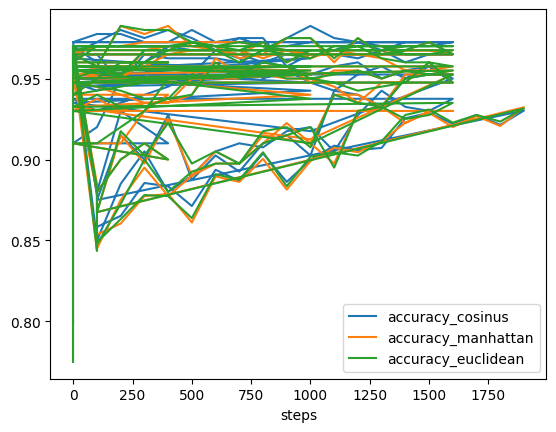

In [21]:
import pandas as pd
eval_df = pd.read_csv('./sbert/eval/triplet_evaluation_results.csv')
eval_df.plot(x='steps', y=['accuracy_cosinus', 'accuracy_manhattan', 'accuracy_euclidean'])